# **04. Plotting a Decision Plot**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

In the previous notebook we applied HDX ensemble reweighting to our BPTI MD trajectories using a range of different $\gamma$ values. Depending on the time you had available, you may have decided to explore either a broad or a narrow range of $\gamma$, so in this notebook we'll interrogate the results of reweighting using a standard set of outputs we provide in the `$HDXER_PATH/tutorials/BPTI/BPTI_reweighting` directory.

As we have previously mentioned, the value of $\gamma$ chosen for an HDXer analysis ultimately controls two further metrics: i) the level of uncertainty in the target dataset, and ii) the level of bias ($W_{app}$) applied to modify the relative weights of the frames in the candidate structural ensemble. By exploring a range of increasing $\gamma$ values, therefore, we have also explored the effects of applying an increasing level of bias to the candidate ensemble, and generated a range of reweighted ensembles with decreasing errors between predicted and target HDX-MS data.

The next step in our analysis aims to answer a seemingly simple question: **What value of $\gamma$, magnitude of bias, or level of error between predicted and target data, is appropriate for us to analyze the final conformational populations of our reweighted ensemble?**

In theory, the answer is simple - we should fit our model (in this case, the relative weights associated with each frame) to recreate our target HDX-MS data as closely as possible without overfitting. Overfitting, in the context of HDX reweighting, implies a final structural ensemble that is fit too closely to the target HDX data, beyond the true level of uncertainty present. Overfitting would therefore result in an unreliable model of the true structural ensemble. This can also be thought of as 'fitting to noise', where the 'noise' can be either systematic or random in nature, and stem from either experimental, HDX predictive model, or sampling inadequacies, as discussed in notebook 3.

In practice, it's difficult for us to assess the true magnitude of the 'noise' in our data, because without further experimentation we're unlikely to be able to establish the accuracy and precision of our predictive model or conformational sampling for each individual protein system. Therefore, we'll use a heuristic approach to select a suitable $\gamma$ value for our analysis, and follow up with checks to the robustness of our results after our analysis is complete.

To aid our selection of a suitable $\gamma$ value we will use a visual analysis aided by a 'decision plot', also know as an 'L-curve'. This notebook describes how to plot a decision plot and analyze its shape to aid the selection of a set of reweighting results for subsequent structural analysis.

### **Output files used to plot a decision plot**

In a 'decision plot' we will create a 2D line plot to describe the relationship between two of the three variables explored across our range of reweighting analyses, namely i) $\gamma$, ii) $W_{app}$, and iii) mean square error (MSE) between our target and predicted HDX-MS data. Any combination of the three variables can be interrogated to aid our decision, however, most commonly we have examined the relationship between the bias applied ($W_{app}$) and the MSE of the predicted to the target HDX-MS data. After reweighting is complete, these two values are written to the `reweighting_gamma_*_work.dat` files. We will start our analysis by creating a function to read in each `*_work.dat` file, store the values in a pandas dataframe, and plot a line plot of $W_{app}$ *vs.* MSE:

In [3]:
def plot_lcurve(title):
    li = []
    for i in np.arange(-3, 1): # Select the range of gamma (i in j*10^i)
        for j in np.arange(1, 10): # Select the range of gamma (j in j*10^i)
            # Read files containing work values from the smallest to the biggest gamma
            try:
                work = os.path.expandvars(f'$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/reweighting_gamma_{j}x10^{i}_work.dat')
                df = pd.read_csv(work, comment='#', header=None, sep='\s+')
                li.append(df)
            except FileNotFoundError:
                pass
    works = pd.concat(li, axis=0, ignore_index=True) 
    works.columns = ['gamma', 'MSE', 'RMSE', 'work']
    
    plt.figure(figsize=(11, 8.5))
    plt.plot(works['MSE'], works['work'], color='teal', linewidth=3, markersize=10, marker='o')
    gamma_2_x = works[works['gamma'] == 2.0]['MSE']
    gamma_2_y = works[works['gamma'] == 2.0]['work']
    plt.annotate("Gamma = 2.0", xy=(gamma_2_x, gamma_2_y), xytext=(gamma_2_x + 0.005, gamma_2_y + 2.0),
                 arrowprops=dict(facecolor='black', shrink=0.05), size=16 )
    plt.title(title)
    plt.xlabel('MSE to target data')
    plt.ylabel('W$_{app}$ / kJ mol$^{-1}$')
    plt.savefig('BPTI_decision_plot.pdf', bbox_inches='tight')

### **Plotting and analyzing an L-curve**

Below, we plot the decision plot for the BPTI reweighting data using the function we have written:

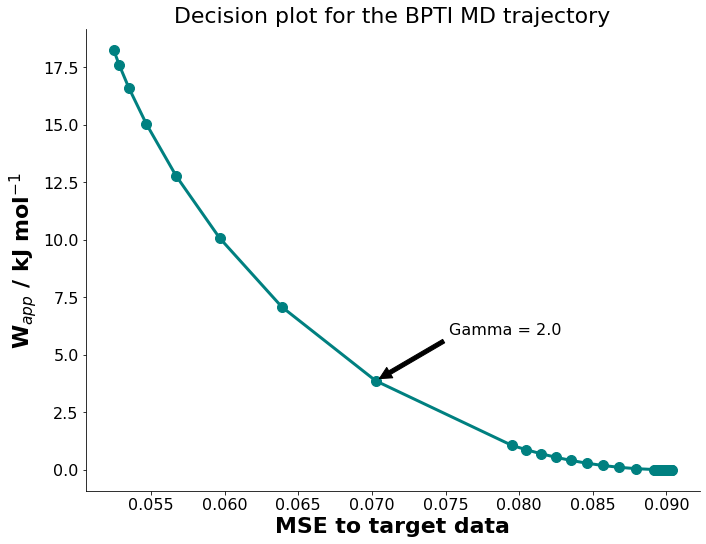

In [4]:
plot_lcurve('Decision plot for the BPTI MD trajectory')

'Fitting to noise' can also be identified as a situation in which the accuracy of the fitted model becomes insensitive to large changes in the underlying model parameters - in this case the weights of each frame in the ensemble. This may be simply characterized as a reweighting that results in a large increase in applied bias (apparent work), for little improvement in accuracy to the target data.

A sensible strategy to choose a suitable gamma value is therefore to look for a sharp increase in $W_{app}$ for little, i.e. an 'elbow' in the decision plot. An additional cutoff metric can be applied to the $W_{app}$ value to keep the applied bias within a reasonable range (say, 2-3 $k_BT$. Here, although there is no abrubt change in the gradient of the decision plot, it is clear that above *ca.* 4 kJ mol$^{-1}$ there are diminishing returns in accuracy as more bias is applied. Therefor, we choose to keep the $W_{app}$ value below 4 kJ mol$^{-1}$ and select an optimal $\gamma$ value of $2\times10^0$ based on the plot above.

### **Plotting deuterated fractions**

Finally, let's visualize the effects of reweighting upon the predicted HDX-MS deuterated fractions. Below, we plot the HDX-MS data from the reweighted ensemble (in green), together with the experimental (blue) and the predicted HDX deuterated fractions from the initial, unbiased, ensemble (orange).

In [5]:
times = np.array([0.167, 1.0, 10.0, 120.0]) # Create a NumPy array with time points in minutes

In [6]:
def read_to_df(file):
    """Read and create a pandas DataFrame for the given argument.
    
    Args:
        file: There are four possible options:
            'segs' - peptide segments
            'expt' - experimental HDX deuterated fractions
            'pred' - predicted HDX deuterated fractions
            'reweighted' - reweighted HDX deuterated fractions
    
    Returns:
        df: A pandas DataFrame containing data for the given argument.
    """
    if file == 'segs':
        # Read and create a pandas DataFrame using a residue segments file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_expt_data/BPTI_residue_segs.txt'),
                         sep='\s+', header=None, names=['ResStr', 'ResEnd'])
    elif file == 'expt':
        # Read and create a pandas DataFrame using an experimental deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_expt_data/BPTI_expt_dfracs.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'pred':
        # Read and create a pandas DataFrame using a predicted deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_calc_hdx/BPTI_SUMMARY_segment_average_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'reweighted':
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/reweighting_gamma_2x10^0_final_segment_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, names=times)
    else:
        print("Incorrect argument given. Please choose one of the following: 'segs' 'expt' 'pred' 'reweighted'")
    return df

In [7]:
def plot_dfracs(*args):
    """Plot HDX deuterated fractions for each time point.
    
    Args:
        *args: 
            'expt' - experimental HDX deuterated fractions
            'pred' - predicted HDX deuterated fractions
            'reweighted' - reweighted HDX deuterated fractions
    """
    fig, axs = plt.subplots(len(times), 1, figsize=(12, 24))
    for i, (ax, t) in enumerate(zip(axs, times)):
        for arg in args:
            if arg in ['expt', 'pred', 'reweighted']:
                xs = np.arange(0, read_to_df(arg).iloc[:, 1].shape[0])
                ax.plot(xs, read_to_df(arg).iloc[:, i], label=arg)
                ax.set_title(f'Labeling time = {t} min')
                ax.legend(loc='upper right')
                ax.set_xticks(xs)
                ax.set_xlim(xs[0], xs[-1])
                ax.set_xticklabels(read_to_df('segs').iloc[:, 1], rotation=90)
                ax.set_ylim(0, 1)
            else:
                print("Incorrect argument given. Please choose one or more of the following: 'expt' 'pred' 'reweighted'")
    fig.text(0.5, 0.095, 'Residue', ha='center', fontsize=22)
    fig.text(0.05, 0.5, 'HDX deuterated fractions', va='center', rotation='vertical', fontsize=22)

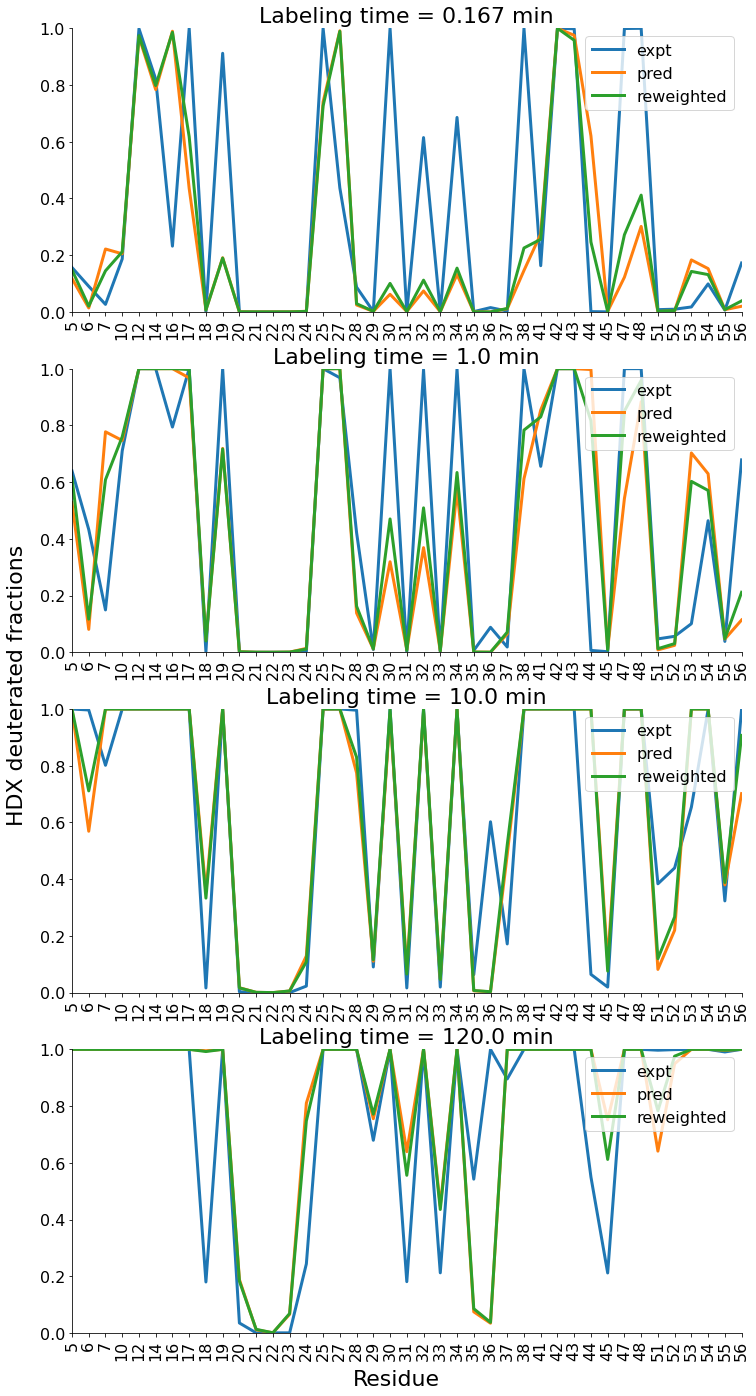

In [8]:
plot_dfracs('expt', 'pred', 'reweighted')

It's clear that the reweighting process has resulted in some improvement in the agreement between the reweighted HDX-MS data and the experimental data. However, this plot got messy and a bit tricky to analyze! Let's visualize the same data using a heatmap, which will allow us to see the changes in deuterated fractions (a.k.a. the $\Delta$HDX) for each residue. This will be shown in the next notebook *05_heatmap.ipynb*.